In [1]:
import numpy
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import ipykernel
import subprocess
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
# import gym

In [2]:
print(numpy.version.version)
print(ipykernel.__version__)
tf.config.list_physical_devices()


1.23.3
6.15.2


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# My personal highscore for that level

In [3]:
highscore = {"commands": [{"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43},
                          {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43},
                          {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43},
                          {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43},
                          {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43},
                          {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43},
                          {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43},
                          {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43},
                          {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43}, {"power": 4, "rotation": -43},
                          {"power": 3, "rotation": -22}, {"power": 3, "rotation": -22}, {"power": 3, "rotation": -22}, {"power": 3, "rotation": -22},
                          {"power": 3, "rotation": -22}, {"power": 3, "rotation": -22}, {"power": 3, "rotation": -22}, {"power": 3, "rotation": -22},
                          {"power": 3, "rotation": -22}, {"power": 3, "rotation": -22}, {"power": 3, "rotation": -22}, {"power": 3, "rotation": -22},
                          {"power": 4, "rotation": -5}, {"power": 4, "rotation": -5}, {"power": 4, "rotation": -5}, {"power": 4, "rotation": -5},
                          {"power": 4, "rotation": -5}, {"power": 4, "rotation": -5}, {"power": 4, "rotation": -5}, {"power": 4, "rotation": -5},
                          {"power": 4, "rotation": -5}, {"power": 4, "rotation": -5}, {"power": 4, "rotation": -5}, {"power": 4, "rotation": -5},
                          {"power": 4, "rotation": -5}, {"power": 4, "rotation": -5}, {"power": 4, "rotation": -5}, {"power": 4, "rotation": -5},
                          {"power": 4, "rotation": -5}, {"power": 3, "rotation": 0}, {"power": 3, "rotation": 0}, {"power": 3, "rotation": 0},
                          {"power": 3, "rotation": 0}, {"power": 3, "rotation": 0}, {"power": 3, "rotation": 0}, {"power": 3, "rotation": 0},
                          {"power": 3, "rotation": 0}, {"power": 3, "rotation": 0}, {"power": 4, "rotation": 0}, {"power": 4, "rotation": 0},
                          {"power": 4, "rotation": 0}, {"power": 4, "rotation": 0}, {"power": 4, "rotation": 0}, {"power": 4, "rotation": 0},
                          {"power": 4, "rotation": 0}, {"power": 4, "rotation": 0}, {"power": 4, "rotation": 0}, {"power": 4, "rotation": 0},
                          {"power": 4, "rotation": 0}, {"power": 4, "rotation": 0}, {"power": 4, "rotation": 0}, {"power": 4, "rotation": 0},
                          {"power": 4, "rotation": 0}], "score": 421}

In [4]:
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

## run and visualize one prerecorded game using GymEnv

In [5]:
from importlib import reload
import MarsLanderGymEnv

reload(MarsLanderGymEnv)

from MarsLanderGymEnv import MarsLanderGymEnv

prerecorded_infos = []

replay_commands = deque(highscore["commands"])

with MarsLanderGymEnv() as env:
    obs = env.reset(seed=42)
    # while True:  # not done:
    while len(replay_commands) > 0:  # not done:
        action = replay_commands.popleft()
        random_action = action
        # random_action = env.action_space.sample()
        # print("action", random_action)
        obs, reward, done, truncated, info = env.step(random_action)
        prerecorded_infos.append(info)
        # print('reward', reward)
        if done:
            # print("is_done")
            break


In [6]:
def generate_df_from_infos(infos):
    states = [kv['state'] for kv in infos]
    json_ary = json.dumps(states)
    df = pd.read_json(json_ary)
    return df

In [7]:
def render_multiple_games(info_df_list):
    import math
    num_games = len(info_df_list)
    columns = 4
    rows = math.ceil(num_games / float(columns))
    ratio = 7000.0 / 3000.0
    x_size = 20
    y_size = x_size / ratio
    _, axs = plt.subplots(rows, columns, figsize=(x_size, y_size))
    flattened_axes = [element for tupl in axs for element in tupl]
    for (infos, df), sub_ax in zip(info_df_list, flattened_axes):
        render_game(infos, df, sub_ax)


In [8]:
def render_game(infos, df, ax):
    coordinates = df[['x', 'y']].to_numpy()
    landing_coordinates = np.array([list(map(int, line.split(' '))) for line in infos[0]['landing_coords']] + [[7000, 0], [0, 0]])
    poly = Polygon(landing_coordinates, facecolor='r')

    # fig, ax = plt.subplots()
    ax.add_patch(poly)
    ax.plot(coordinates[:, 0], coordinates[:, 1])
    ax.set_xlim([0, 7000])
    ax.set_ylim([0, 3000])

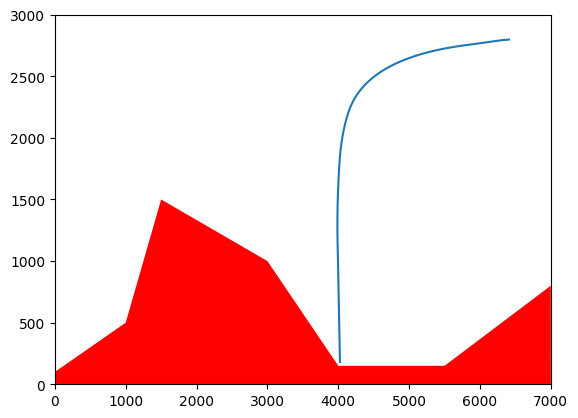

In [9]:
_, ax = plt.subplots()

render_game(prerecorded_infos, generate_df_from_infos(prerecorded_infos), ax)

## Stesstest 100 games

In [10]:
%%time

n = 100

import time
from MarsLanderGymEnv import MarsLanderGymEnv

with MarsLanderGymEnv() as env:
    run_times = []

    start = time.time()

    for episode in range(n):
        s = time.time()
        done = False
        obs = env.reset()
        while True:  # not done:
            random_action = env.action_space.sample()
            # print("action", random_action)
            obs, reward, done, truncated, info = env.step(random_action)
            # print('reward', reward)
            if done:
                # print("is_done")
                break
        e = time.time()
        run_times.append([episode, (e - s) * 1000])

    end = time.time()

    run_times = np.array(run_times)


CPU times: user 179 ms, sys: 58.3 ms, total: 237 ms
Wall time: 1.86 s


## looks like hotspot optimization in node vm

Text(0.5, 1.0, 'runtime over first 100 runs')

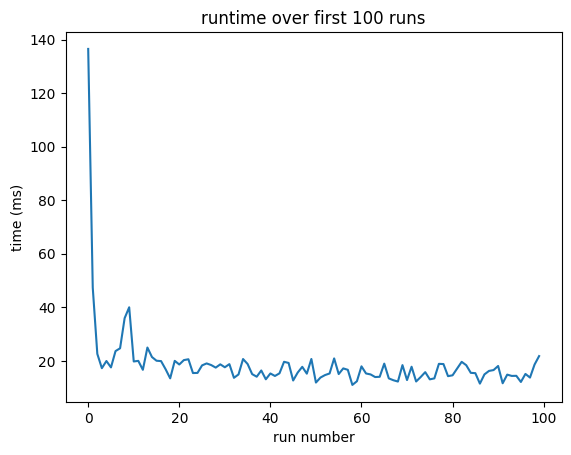

In [11]:
fig, ax = plt.subplots()
display_lim = n
ax.plot(run_times[:display_lim, 0], run_times[:display_lim, 1])
ax.set_xlabel('run number')
ax.set_ylabel('time (ms)')
ax.set_title(f'runtime over first {display_lim} runs')

## display one game with random inputs


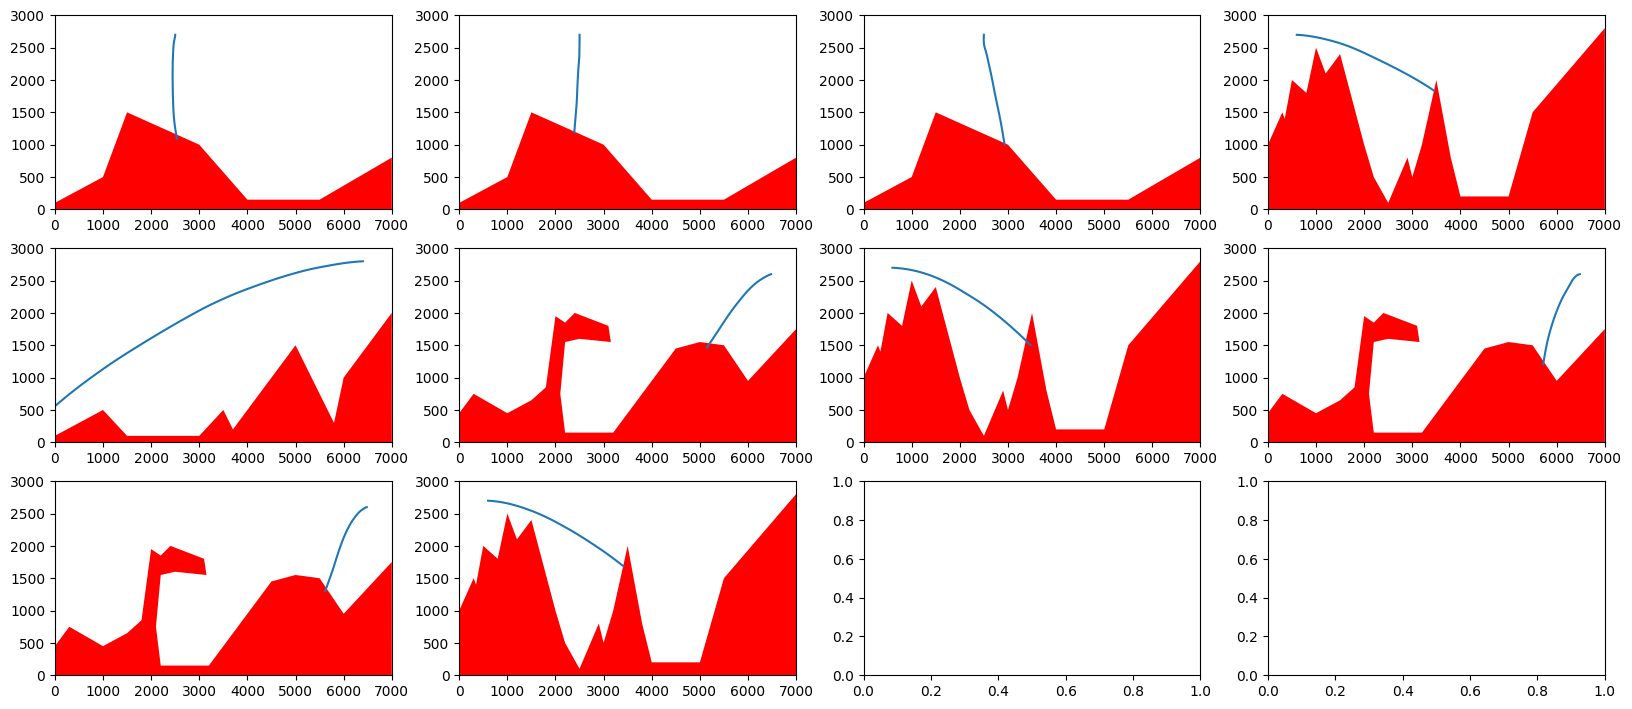

In [12]:
from MarsLanderGymEnv import MarsLanderGymEnv

info_df_list = []
with MarsLanderGymEnv() as env:
    for _ in range(0, 10):
        infos = []
        obs = env.reset()
        while True:  # not done:
            random_action = env.action_space.sample()
            # print("action", random_action)
            obs, reward, done, truncated, info = env.step(random_action)
            infos.append(info)
            # print('reward', reward)
            if done:
                # print("is_done")
                break

        info_df_list.append((infos, generate_df_from_infos(infos)))

render_multiple_games(info_df_list)
